# Импортирование библиотек

In [26]:
import numpy as np
from scipy.linalg import lu
from sklearn.utils.extmath import randomized_svd
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
from numpy import linalg as LA
from tqdm import tqdm
from scipy.linalg import orth
import time
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

# Реализация алгоритмов

In [2]:
def eigsvd(A: np.ndarray):
    m, n = A.shape
    B = np.dot(A.T, A)
    D, V = np.linalg.eig(B)
    S = np.diag(np.abs(D))
    U = np.dot(np.dot(A, V), np.linalg.inv(S))
    return U, S, V.T

In [3]:
def rSVDPI(A, k, p):
    s = 5
    m, n = A.shape
    O = np.random.randn(n, k+s)
    Q = A @ O
    for i in range(p+1):
        if i < p:
            Q, _ = lu(Q, permute_l=True)
        else:
            Q, _, _ = eigsvd(Q)
            break
        Q = A @ (A.T @ Q)
        
    B = Q.T @ A
    V, S, U = eigsvd(B.T)
    ind = slice(s+1, k+s)
    
    return (Q @ U)[:, ind], S[ind, ind], V[:, ind]

In [4]:
def rSVDBKI(A, k, p, s=5):
    m, n = A.shape

    if s <= 5:
        s = 5

    O = np.random.randn(n, k+s)

    tmp = np.dot(A, O)
    H0, _ = lu(tmp, permute_l=True)
    H = H0
    Hi = H0
    for i in range(1, p):
        Hi, _ = lu(np.dot(A, np.dot(A.T, Hi)), permute_l=True)
        H = np.hstack((H, Hi))
    Q = orth(H)
    B = np.dot(Q.T, A)

    V, S, U = eigsvd(B.T)

    ind = slice((k+s)*(p+1)-k+1,(k+s)*(p+1))

    U, S, V = np.dot(Q, U)[:, ind], S[ind, ind], V[:, ind]

    return U, S, V

# Расчет времени и ошибки для плотных матриц

In [64]:
time_svd_default = []
time_rsvd_default = []
time_eigsvd = []
time_rSVDPI = []
time_rSVDBKI = []

err_svd_default = []
err_rsvd_default = []
err_eigsvd = []
err_rSVDPI = []
err_rSVDBKI = []

for n in tqdm(range(50, 1000, 50)):
    
    A = np.random.rand(int(n/10), n)
    
    start = time.time()
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    time_svd_default.append(time.time() - start)
    err_svd_default.append(LA.norm(A - U*S@Vh, 'fro'))
    
    start = time.time()
    U, S, Vh = randomized_svd(A, n_components=2)
    time_rsvd_default.append(time.time() - start)
    err_rsvd_default.append(LA.norm(A - U*S@Vh, 'fro'))
    
    start = time.time()
    U, S, V = eigsvd(A)
    time_eigsvd.append(time.time() - start)
    err_eigsvd.append(LA.norm(A - U@S@V.T, 'fro'))
    
    start = time.time()
    U, S, V = rSVDPI(A, k=100, p=15)
    time_rSVDPI.append(time.time() - start)
    err_rSVDPI.append(LA.norm(A - U@S@V.T, 'fro'))
    
    start = time.time()
    U, S, V = rSVDBKI(A, k=100, p=15)
    time_rSVDBKI.append(time.time() - start)
    err_rSVDBKI.append(LA.norm(A - U@S@V.T, 'fro'))

100%|██████████| 19/19 [00:06<00:00,  2.76it/s]


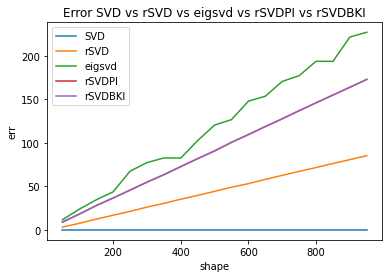

In [65]:
# создание трех массивов
x = range(50, 1000, 50)

# построение графиков на одном плоте
plt.plot(x, err_svd_default, label='SVD')
plt.plot(x, err_rsvd_default, label='rSVD')
plt.plot(x, err_eigsvd, label='eigsvd')
plt.plot(x, err_rSVDPI, label='rSVDPI')
plt.plot(x, err_rSVDBKI, label='rSVDBKI')
# добавление легенды и заголовка
plt.legend()
plt.title('Error SVD vs rSVD vs eigsvd vs rSVDPI vs rSVDBKI')
plt.xlabel('shape')
plt.ylabel('err')
# отображение графика
plt.show() 


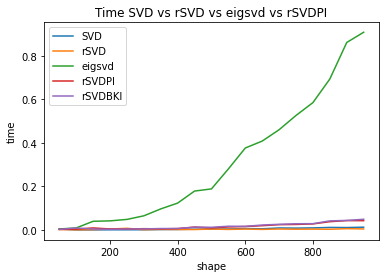

In [70]:
# создание трех массивов
x = range(50, 1000, 50)

# построение графиков на одном плоте
plt.plot(x, time_svd_default, label='SVD')
plt.plot(x, time_rsvd_default, label='rSVD')
plt.plot(x, time_eigsvd, label='eigsvd')
plt.plot(x, time_rSVDPI, label='rSVDPI')
plt.plot(x, time_rSVDBKI, label='rSVDBKI')
# добавление легенды и заголовка
plt.legend()
plt.title('Time SVD vs rSVD vs eigsvd vs rSVDPI')
plt.xlabel('shape')
plt.ylabel('time')
# отображение графика
plt.show() 

# Расчет времени и ошибки для разреженных матриц

In [75]:
time_svd_default = []
time_rsvd_default = []
time_eigsvd = []
time_rSVDPI = []
time_rSVDBKI = []

err_svd_default = []
err_rsvd_default = []
err_eigsvd = []

for n in tqdm(range(50, 1000, 50)):
    
    rng = default_rng()
    rvs = stats.poisson(25, loc=10).rvs
    A = random(n, int(n/5), density=0.5, random_state=rng, data_rvs=rvs)
    A = A.A
    
    start = time.time()
    U, S, Vh = svds(A, k=4)
    time_svd_default.append(time.time() - start)
    err_svd_default.append(LA.norm(A - U@np.diag(S)@Vh, 'fro'))
    
    start = time.time()
    U, S, Vh = randomized_svd(A, n_components=2)
    time_rsvd_default.append(time.time() - start)
    err_rsvd_default.append(LA.norm(A - U*S@Vh, 'fro'))
    
    start = time.time()
    U, S, V = eigsvd(A)
    time_eigsvd.append(time.time() - start)
    err_eigsvd.append(LA.norm(A - U@S@V.T, 'fro'))
    
    start = time.time()
    U, S, V = rSVDPI(A, k=100, p=15)
    time_rSVDPI.append(time.time() - start)
    err_rSVDPI.append(LA.norm(A - U@S@V.T, 'fro'))
    
    start = time.time()
    U, S, V = rSVDBKI(A, k=100, p=15)
    time_rSVDBKI.append(time.time() - start)
    err_rSVDBKI.append(LA.norm(A - U@S@V.T, 'fro'))

100%|██████████| 19/19 [00:08<00:00,  2.35it/s]


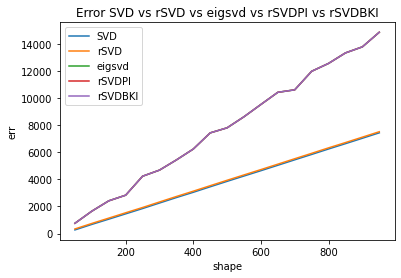

In [76]:
# создание трех массивов
x = range(50, 1000, 50)

# построение графиков на одном плоте
plt.plot(x, err_svd_default, label='SVD')
plt.plot(x, err_rsvd_default, label='rSVD')
plt.plot(x, err_eigsvd, label='eigsvd')
plt.plot(x, err_eigsvd, label='rSVDPI')
plt.plot(x, err_eigsvd, label='rSVDBKI')

# добавление легенды и заголовка
plt.legend()
plt.title('Error SVD vs rSVD vs eigsvd vs rSVDPI vs rSVDBKI')
plt.xlabel('shape')
plt.ylabel('err')
# отображение графика
plt.show() 

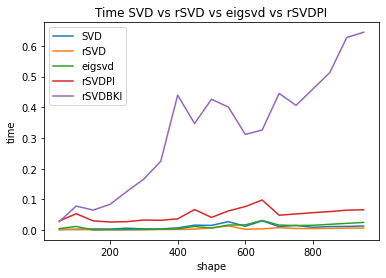

In [77]:
# создание трех массивов
x = range(50, 1000, 50)

# построение графиков на одном плоте
plt.plot(x, time_svd_default, label='SVD')
plt.plot(x, time_rsvd_default, label='rSVD')
plt.plot(x, time_eigsvd, label='eigsvd')
plt.plot(x, time_rSVDPI, label='rSVDPI')
plt.plot(x, time_rSVDBKI, label='rSVDBKI')
# добавление легенды и заголовка
plt.legend()
plt.title('Time SVD vs rSVD vs eigsvd vs rSVDPI')
plt.xlabel('shape')
plt.ylabel('time')
# отображение графика
plt.show() 